In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
from collections import defaultdict, Counter
from file_storage import FileStorage
from heapq import heappush, heappop


from bs4 import BeautifulSoup
from urllib.parse import urljoin
from urllib.parse import urldefrag
import pickle
import tqdm

Storage немного пополнился со времен задания про pagerank, поэтому пересчитаем соседей и пейджранк

In [2]:
file_storage = FileStorage('../filtered_storage')
len(file_storage)

157154

In [3]:
def extract_links_from_html(url, html):
    parser = BeautifulSoup(html)
    return [
        urldefrag(urljoin(url, link.get('href'))).url
        for link in parser.findAll('a')
    ]


def build_neighbors(storage):
    result = {}
    for url, page in tqdm.tqdm(storage.items(), total=len(storage)):
        result[url] = [
            link for link in extract_links_from_html(url, page)
            if link in storage
        ]
    return result


def normilize_pagerank(pagerank, normalization_func=max):
    normalization = normalization_func(pagerank.values())
    return {url: rank / normalization for url, rank in pagerank.items()}


def calc_diff(rank_a, rank_b):
    return sum(
        (value_a - rank_b[key]) ** 2
        for key, value_a in rank_a.items()
    ) / len(rank_a)


def calc_pagerank(neighbors, iterations=20, delta=0.1, prev_pagerank=None, min_diff=1e-20):
    if prev_pagerank is None:
        prev_pagerank = defaultdict(lambda: 1 / len(neighbors))

    for ind in range(iterations):
        print('{} iteration, India rank: {}'.format(
            ind, prev_pagerank['https://simple.wikipedia.org/wiki/India']
        ))
        mean_pagerank = sum(prev_pagerank.values()) / len(prev_pagerank)
        pagerank = defaultdict(lambda: mean_pagerank * delta)
        for url in neighbors.keys():
            curr_neighbor_list = neighbors[url]
            for neighbor_url in curr_neighbor_list:
                pagerank[neighbor_url] += prev_pagerank[url] / len(curr_neighbor_list) * (1 - delta)
        pagerank = normilize_pagerank(pagerank)
        diff = calc_diff(pagerank, prev_pagerank)
        print('diff: ' + str(diff))
        if diff < min_diff:
            break
        prev_pagerank = pagerank
    return pagerank

In [6]:
neighbors = build_neighbors(file_storage)

100%|██████████| 157154/157154 [1:04:57<00:00, 40.32it/s]


In [7]:
with open('neighbors.pkl', 'wb') as f_out:
    pickle.dump(neighbors, f_out)

In [4]:
with open('neighbors.pkl', 'rb') as nei_file:
    neighbors = pickle.load(nei_file, encoding='utf-8')

In [5]:
neighbors_sets = {url: set(neighbor_list) for url, neighbor_list in neighbors.items()}

In [9]:
pagerank = calc_pagerank(neighbors, iterations=50)

0 iteration, India rank: 6.363185155961668e-06
diff: 6.498830639862381e-06
1 iteration, India rank: 0.011153841633878397
diff: 9.695499152897899e-08
2 iteration, India rank: 0.016433137199733355
diff: 1.7837428660129294e-08
3 iteration, India rank: 0.01967546741884423
diff: 4.929598694172049e-09
4 iteration, India rank: 0.020752173792810955
diff: 1.723636568875436e-09
5 iteration, India rank: 0.021038478362333777
diff: 6.796160961582491e-10
6 iteration, India rank: 0.0210928643021524
diff: 2.910212610972103e-10
7 iteration, India rank: 0.021083982027049454
diff: 1.348633558393078e-10
8 iteration, India rank: 0.021062598526175078
diff: 6.566972927109686e-11
9 iteration, India rank: 0.021042581726013608
diff: 3.391479836856501e-11
10 iteration, India rank: 0.021026925060522537
diff: 1.8059773454037743e-11
11 iteration, India rank: 0.021015229917794795
diff: 1.0033340249107487e-11
12 iteration, India rank: 0.02100658578423475
diff: 5.677615890879299e-12
13 iteration, India rank: 0.0210000

In [6]:
def dump_pagerank(pagerank, path='pagerank_results.txt'):
    with open(path, 'w') as pagerank_file:
        for url, rank in pagerank.items():
            pagerank_file.write("{:>7.6} {}\n".format(rank, url))


def load_pagerank(path='pagerank_results.txt'):
    with open(path) as pagerank_file:
        pagerank = {}
        for line in pagerank_file:
            rank, url = line.strip().split()
            pagerank[url] = float(rank)
        return pagerank

In [13]:
dump_pagerank(pagerank)

In [7]:
pagerank = load_pagerank()

neighbors - словарь url -> исходящие ссылки, построим словарь для входящих ссылок

In [13]:
incoming_edges = defaultdict(set)
for url, neighbor_iterable in neighbors.items():
    for neighbor in neighbor_iterable:
        incoming_edges[neighbor].add(url)

Читерный обход

In [8]:
def cheat_crawling(pagerank, neighbors, seed='https://simple.wikipedia.org/wiki/Main_Page'):
    priority_queue = []
    seen = {seed}
    pagerank_order = []
    heappush(priority_queue, (-pagerank[seed], seed))
    
    while priority_queue:
        rank, url = heappop(priority_queue)
        pagerank_order.append(-rank)
        for neighbor in neighbors[url]:
            if neighbor not in seen:
                heappush(priority_queue, (-pagerank[neighbor], neighbor))
                seen.add(neighbor)
    return pagerank_order

In [32]:
cheat = np.cumsum(cheat_crawling(pagerank, neighbors_sets))
len(cheat)

141530

Получилось, что обошли не весь storage. В принципе это возможно, ведь когда мы качали содержимое википедии, мы обходили страницы с категориями, а сейчас мы их удалили. Многовато правда таких страниц, лучше убедимся, что нет баги в обходе.

Напишем BFS

In [10]:
def BFS_crawling(pagerank, neighbors, seed='https://simple.wikipedia.org/wiki/Main_Page'):
    queue = [seed]
    seen = {seed}
    pagerank_order = []
    
    while queue:
        url = queue.pop(0)
        pagerank_order.append(pagerank[url])
        for neighbor in neighbors[url]:
            if neighbor not in seen:
                queue.append(neighbor)
                seen.add(neighbor)
    return pagerank_order, seen

In [37]:
bfs_pagerank_order, seen = BFS_crawling(pagerank, neighbors_sets)

In [14]:
Counter([len(incoming_edges[url]) for url in (set(file_storage.keys()) - seen)]).items()

dict_items([(1, 12411), (2, 2583), (17, 16), (4, 95), (3, 393), (5, 61), (6, 24), (16, 18), (18, 4), (13, 3), (8, 6), (19, 1), (20, 2), (9, 2), (7, 2), (14, 1), (10, 1), (15, 1)])

In [15]:
diff = set(file_storage.keys()) - seen

In [16]:
for url in (set(file_storage.keys()) - seen):
    if len(incoming_edges[url]) > 18:
        print(url)
        print(incoming_edges[url])

https://simple.wikipedia.org/wiki/University_of_the_City_of_Manila
{'https://simple.wikipedia.org/wiki/PLM_College_of_Science', 'https://simple.wikipedia.org/wiki/Pamantasan_ng_Lungsod_ng_Maynila', 'https://simple.wikipedia.org/wiki/PLM_College_of_Tourism,_Hotel_%26_Travel_Industry_Management', 'https://simple.wikipedia.org/wiki/PLM_College_of_Mass_Communication', 'https://simple.wikipedia.org/wiki/University_of_the_City_of_Manila', 'https://simple.wikipedia.org/wiki/President_of_the_University_of_the_City_of_Manila', 'https://simple.wikipedia.org/wiki/Adel_Tamano', 'https://simple.wikipedia.org/wiki/PLM_College_of_Law', 'https://simple.wikipedia.org/wiki/PLM_College_of_Human_Development', 'https://simple.wikipedia.org/wiki/PLM_College_of_Tourism,_Hotel_and_Travel_Industry_Management', 'https://simple.wikipedia.org/wiki/PLM_College_of_Accountancy_%26_Economics', 'https://simple.wikipedia.org/wiki/Benjamin_Tayabas', 'https://simple.wikipedia.org/wiki/PLM_College_of_Medicine', 'https://s

In [17]:
for url in diff:
    if any(nei not in diff for nei in incoming_edges[url]):
        print(url)
        print(incoming_edges[url])

Получается да, на не найденные при обходе статьи не ссылается ни одной статьи из тех, что были посещены при обходе.

In [38]:
bfs = np.cumsum(bfs_pagerank_order)

Напишем рандомный обход

In [19]:
def random_crawling(pagerank, neighbors, seed='https://simple.wikipedia.org/wiki/Main_Page'):
    queue = [seed]
    seen = {seed}
    pagerank_order = []
    
    while queue:
        rnd_ind = np.random.randint(0, len(queue))
        url = queue.pop(rnd_ind)
        pagerank_order.append(pagerank[url])
        for neighbor in neighbors[url]:
            if neighbor not in seen:
                queue.append(neighbor)
                seen.add(neighbor)
    return pagerank_order, seen

In [20]:
random_pagerank_order, random_seen = random_crawling(pagerank, neighbors_sets)
random = np.cumsum(random_pagerank_order)

In [21]:
random_seen == seen

True

Обошли те же вершины, что и при BFS. Похоже все правильно

Напишем обход с приоритезацией по числу вершин

In [25]:
def priority_by_in_degree_crawling(pagerank, neighbors, seed='https://simple.wikipedia.org/wiki/Main_Page'):
    num_neighbors = defaultdict(int)
    num_neighbors[seed] = 0
    visited = set()
    pagerank_order = []
    
    while num_neighbors:
        url, _ = max(num_neighbors.items(), key=lambda x: x[1])
        del num_neighbors[url]
        visited.add(url)
        pagerank_order.append(pagerank[url])
        for neighbor in neighbors[url]:
            if neighbor not in visited:
                num_neighbors[neighbor] += 1
    return pagerank_order

In [26]:
priority_by_in_degree = np.cumsum(priority_by_in_degree_crawling(pagerank, neighbors_sets))

In [27]:
len(priority_by_in_degree)

141530

В супер читерной оставим только те страницы, до которых можем дотянуться при обходе

In [28]:
super_cheat = np.cumsum(sorted((value for url, value in pagerank.items() if url in seen), reverse=True))

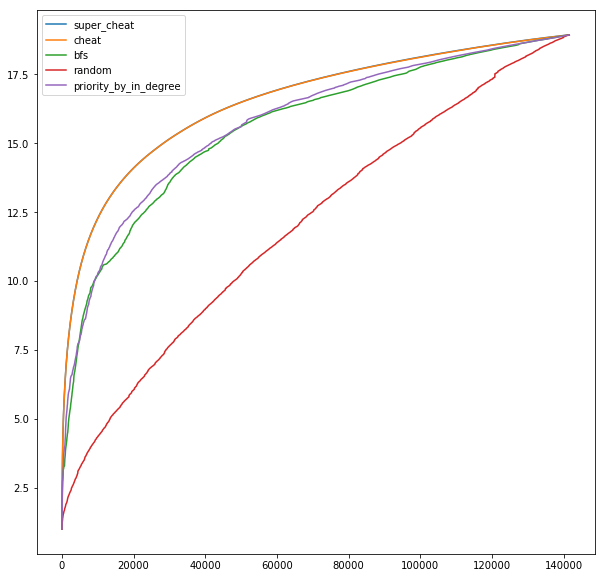

In [39]:
x = np.arange(len(cheat))
plt.figure(figsize=(10, 10))
plt.plot(x, super_cheat, label='super_cheat')
plt.plot(x, cheat, label='cheat')
plt.plot(x, bfs, label='bfs')
plt.plot(x, random, label='random')
plt.plot(x, priority_by_in_degree, label='priority_by_in_degree')
plt.legend()
plt.show()

Читерные очень похожи, давайте посмотрим поближе

In [40]:
cheat[:20]

array([1.       , 1.0332813, 1.1556423, 1.2267954, 1.2700391, 1.3081188,
       1.3459468, 1.3790978, 1.4102172, 1.4412547, 1.471093 , 1.5007949,
       1.5291381, 1.5554132, 1.5804116, 1.6048601, 1.6289775, 1.6530108,
       1.6763263, 1.6992608])

In [41]:
super_cheat[:20]

array([1.       , 1.122361 , 1.1935141, 1.2367578, 1.2748375, 1.3126655,
       1.3459468, 1.3790978, 1.4119371, 1.4430565, 1.474094 , 1.5039323,
       1.5336342, 1.5619774, 1.5882525, 1.6132509, 1.6376994, 1.6618168,
       1.6858501, 1.7091656])

In [43]:
(super_cheat - cheat >= 0).all()

True

Все же разница есть, но действительно не особо большая